Suppose we want to solve the system of linear equations

$${\displaystyle \mathbf {A} \mathbf {x} =\mathbf {b} }$$
for the vector $x$, where the known $n × n$ matrix $A$ is symmetric (i.e., $A^T = A$), positive-definite (i.e. $xTAx > 0$ for all non-zero vectors $x$ in $R^n$), and real, and $b$ is known as well. We denote the unique solution of this system by $x$.

In [1]:
import numpy as np
from scipy.sparse.linalg import cg

from sklearn.datasets import make_sparse_spd_matrix as mspdm
#from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm
#import scipy.stats as stats
#import scipy.sparse as sparse

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

np.random.seed(210)

Here i use __make_sparse_spd_matrix__ function from __sklearn.datasets__ in order to generate  $n × n$ matrix $A$ which must be _sparse symmetric positive-definite and real_. 

In [2]:
# def sprandsym(n, density):
#     rvs = stats.norm().rvs
#     X = sparse.random(n, n, density=density, data_rvs=rvs)
#     upper_X = sparse.triu(X) 
#     result = upper_X + upper_X.T - sparse.diags(X.diagonal())
#     return result

# A = sprandsym(size, 0.01)
# #print(repr(A))
# # <5000x5000 sparse matrix of type '<class 'numpy.float64'>'
# #   with 249909 stored elements in Compressed Sparse Row format>

# A = A.toarray()
# #A

def gen_matrix(size):
    A = mspdm(size, 0.99)
    return(A)

In [3]:
#checking if matrix A satisfy all requirements
def check_matrix(A):
    #Check A for being Positive Definite
    np.linalg.cholesky(A)

    # # check that the matrix A is symmetric. The difference should have no non-zero elements
    #A = A.toarray()
    #assert (A - A.T).nnz == 0

Here i generate vectors $x$ and $b$.

In [4]:
#generating x and b vectors
def gen_xb(size):
    b = np.random.rand(size,1)
    #np.dtype(b) #why error?
    x = (np.zeros(size)+1.0).reshape(-1, 1)
    return x, b

Here i generate a Jacobi preconditioner $n × n$ matrix $M$: $M =$ diag$(A)$.

In [5]:
#generating Jacobi preconditioner
def gen_precond(A, size):
    M = (np.zeros(size*size)).reshape(-1, size)
    i = 0
    j = 0
    while i < size:
        while j < size:
            if(j==i):
                M[i][j]=A[i][j]
            j=j+1
        i=i+1
        j=0
    return(M)

Simple examples:

From Wiki article about Conjugate Gradient method https://en.wikipedia.org/wiki/Conjugate_gradient_method

In [6]:
#From Wiki
A_e1 = np.array([[4,1],[1,3]])
b_e1 = np.array([1,2]).reshape(-1, 1)
x_e1 = np.array([2,1]).reshape(-1, 1)

#%timeit cg(A_e1,b_e1)
#print(cg(A_e1,b_e1)[0]) #correct answer
#[0.09090909 0.63636364]

From Амосов А.А., Дубинский Ю.А., Копченова Н.В. Вычислительные методы для инженеров. http://pnu.edu.ru/media/filer_public/2013/04/10/6-1_amosov-dubinsky-kopchenova_1994.pdf p284.

In [7]:
#From Amosov
A_e2 = np.array([[2,0],[0,4]])
b_e2 = np.array([4,4]).reshape(-1, 1)
x_e2 = np.array([1,1]).reshape(-1, 1)

#%timeit cg(A_e2,b_e2)
#print(cg(A_e2,b_e2)[0]) #correct answer
#[2. 1.]

My realization of the method. Reworked code Wiki article about Conjugate Gradient method https://en.wikipedia.org/wiki/Conjugate_gradient_method

k - step
r - residual of the k step
p - conjugate vector


In [8]:
#conjugate gradients method realisation
def my_cg(A,b,x):
    r = b - A @ x # the first residual
    p = r # the first basis vectop p
    rsold = r.T @ r
    k = 0
    while k < len(A)*10: # should converge in n steps (but it does not :( )
        Ap = A @ p
        alpha = rsold / (p.T @ Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = r.T @ r
        if norm(r) < 1e-10:
            print("1e-10 Broken")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

        k = k + 1
    print("Counted in:", k, "steps")
    return x

My realization of the method. Reworked code Wiki article about Conjugate Gradient method https://en.wikipedia.org/wiki/Conjugate_gradient_method.<br>
Also used this: An Introduction to the Conjugate Gradient Method Without the Agonizing Pain http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf p39 to learn about preconditioning.

In [9]:
#conjugate gradients method realisation with Jacobi preconditioner
def my_cg_prec(A,b,x,M):
    M_inv = np.linalg.inv(M)
    r = b - A @ x
    z = M_inv @ r
    p = z
    i = 0
    while i < len(A)*10: # should converge in n steps (but it does not :( )
        Ap = A @ p
        alpha = (r.T @ z) / (p.T @ Ap)
        x = x + alpha * p
        ztr_old = z.T @ r
        r = r - alpha * Ap
        if norm(r) < 1e-10:
            print("1e-10 Broken")
            break
        z = M_inv @ r
        betta = (z.T @ r)/(ztr_old)
        p = z + betta * p

        i = i+1
    print("Counted in:", i, "steps")
    return x

Testing my code on the known problems(from Wiki and Amosov).

In [10]:
#my_cg(A_e1,b_e1,x_e1) #correct

In [11]:
#my_cg(A_e2,b_e2,x_e2) #correct

In [12]:
count = 25
y = np.zeros(count-1)
z = np.zeros(count-1)

i = 1
while i < count:
    size = 100*i
    A = gen_matrix(size)
#    check_matrix(A)
    x,b = gen_xb(size)
    M = gen_precond(A, size)
#    check_matrix(M)
    CG = cg(A,b,x)[0]
    My = my_cg(A,b,x)
    My_p = my_cg_prec(A,b,x,M)
    
    print('**********NORMAL**********')
    #normal
    j = 0
    summa = 0
    while j < size:
        #print(CG[j]-My[j])
        summa += abs(CG[j]-My[j])
        j = j + 1
    print(i,"LOOP COMPLETED size =",size)
    mer = summa/size
    y[i-1] = mer
    print('mean error =', mer)
    
    print('**********PRECONDITIONED**********')
    #preconditioned
    j = 0
    summa = 0
    while j < size:
        #print(CG[j]-My_p[j])
        summa += abs(CG[j]-My_p[j])
        j = j + 1
    print(i,"LOOP COMPLETED size =",size)
    mer = summa/size
    z[i-1] = mer
    print('mean error =', mer)
    
#    M_inv @ A is better conditioned than A
#    print('A condition number =', np.linalg.cond(A))
#    M_inv = np.linalg.inv(M)
#    print('M_inv @ A condition number =', np.linalg.cond(M_inv @ A))

    print()
    i = i + 1

    

1e-10 Broken
Counted in: 35 steps
1e-10 Broken
Counted in: 33 steps
**********NORMAL**********
1 LOOP COMPLETED size = 100
mean error = [2.8134203e-06]
**********PRECONDITIONED**********
1 LOOP COMPLETED size = 100
mean error = [2.81342086e-06]

1e-10 Broken
Counted in: 64 steps
1e-10 Broken
Counted in: 61 steps
**********NORMAL**********
2 LOOP COMPLETED size = 200
mean error = [7.37651602e-06]
**********PRECONDITIONED**********
2 LOOP COMPLETED size = 200
mean error = [7.37651509e-06]

1e-10 Broken
Counted in: 101 steps
1e-10 Broken
Counted in: 94 steps
**********NORMAL**********
3 LOOP COMPLETED size = 300
mean error = [1.10326547e-05]
**********PRECONDITIONED**********
3 LOOP COMPLETED size = 300
mean error = [1.10326539e-05]

1e-10 Broken
Counted in: 157 steps
1e-10 Broken
Counted in: 142 steps
**********NORMAL**********
4 LOOP COMPLETED size = 400
mean error = [1.0635308e-05]
**********PRECONDITIONED**********
4 LOOP COMPLETED size = 400
mean error = [1.06353041e-05]

1e-10 Broke

Lets plot mean error for each loop:

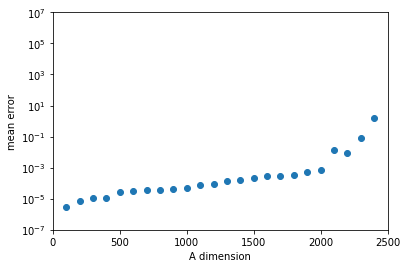

In [13]:
#for normal
plt.xlim([0, 2500])
plt.ylim([1e-7, 1e+7])

x_axis = np.arange(1,i)*100
 
# Plot
plt.scatter(x_axis, y)
plt.xlabel('A dimension')
plt.ylabel('mean error')
plt.yscale('log')
plt.show()

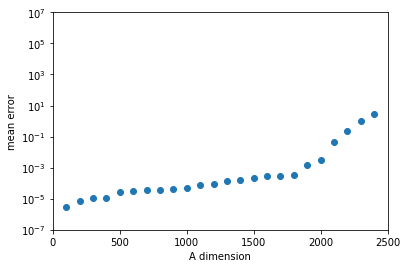

In [14]:
#for preconditioned
plt.xlim([0, 2500])
plt.ylim([1e-7, 1e+7])

x_axis = np.arange(1,i)*100
 
# Plot
plt.scatter(x_axis, z)
plt.xlabel('A dimension')
plt.ylabel('mean error')
plt.yscale('log')
plt.show()

If we have unlimited steps preconditioned algorith is cheaper, but gives worse answer
With steps limited to n the preconditioned algorithm is cheaper and more precise

Literature:
1. Амосов А.А., Дубинский Ю.А., Копченова Н.В. Вычислительные методы для инженеров. http://pnu.edu.ru/media/filer_public/2013/04/10/6-1_amosov-dubinsky-kopchenova_1994.pdf p284.
2. Wiki article about Conjugate Gradient method 
https://en.wikipedia.org/wiki/Conjugate_gradient_method
3. Preconditioning: An Introduction to the Conjugate Gradient Method Without the Agonizing Pain http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf p39
3. How to randomly generate sparse matrices in Python: https://docs.scipy.org/doc/scipy/reference/sparse.html <br>Or BETTER: https://stackoverflow.com/questions/26895011/python-how-to-use-python-to-generate-a-random-sparse-symmetric-matrix <br> Or even BETTER (used in current version): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_sparse_spd_matrix.html

Honorable mentions: 
1. The Concept of Conjugate Gradient Descent in Python. http://ikuz.eu/2015/04/15/the-concept-of-conjugate-gradient-descent-in-python/
2. Iterative methods lab. Jacobi preconditioned conjugate gradients method. https://www.kth.se/social/files/5885d039f2765429974418ce/Lab1.pdf
